# Schneider Electric European Hackathon - Zero deforestation mission

<a href="https://colab.research.google.com/drive/1C7KVFQSJsCCURw8nEMX69bdKC6uzSkyw?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

## What is our goal?

* For this challenge, you will have to predict the class of the deforested area.

## Let's grab the library:

Today we will be using the `fastai` library.

In [1]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

Below you will find the exact imports for everything we use today

In [2]:
import numpy as np
import pandas as pd
from fastcore.xtras import Path # @patch'd properties to the Pathlib module

from fastai.callback.fp16 import to_fp16
from fastai.callback.schedule import fit_one_cycle, lr_find 

from fastai.data.block import CategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter

from fastai.interpret import ClassificationInterpretation
from fastai.learner import Learner

from fastai.metrics import error_rate

from fastai.vision.augment import aug_transforms, RandomResizedCrop
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageDataLoaders, ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models.resnet import resnet34, resnet50

Overall process using machine learning models and fastai:
1. Make our `DataLoaders`
2. Make a `Learner` with some "equipment"
3. Train

## Looking at Data

For this challenge, you will have 2 CSVs: Train and Test. As their names indicate, the first one will be used to train your classification model on the forest images and test to know to which label they belong. It is important to remember to be careful with the paths for reading images in the train_test_data folder.

Importing train dataframe (.csv)

In [3]:
url_train = "https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/SchneiderElectricEuropeanHackathon22/train.csv"
df_train = pd.read_csv(url_train)
df_train.head()

,label,latitude,longitude,year,example_path
0,0,-2.051853,111.826093,2001,train_test_data/train/1297.png
1,2,-1.989349,105.309496,2013,train_test_data/train/1199.png
2,0,1.223256,100.702217,2014,train_test_data/train/1348.png
3,0,-2.342948,103.890226,2008,train_test_data/train/2214.png
4,0,-0.126555,101.758175,2011,train_test_data/train/2220.png


Importing test dataframe (.csv)

In [4]:
url_test = "https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/SchneiderElectricEuropeanHackathon22/test.csv"
df_test = pd.read_csv(url_test)
df_test.head()

,latitude,longitude,year,example_path
0,0.761681,122.755954,2006,train_test_data/test/69.png
1,-8.059785,113.053791,2007,train_test_data/test/469.png
2,-2.006610,111.746316,2002,train_test_data/test/6.png
3,0.901765,114.042495,2016,train_test_data/test/351.png
4,1.911210,100.829633,2008,train_test_data/test/1001.png


Importing the dataset images

In [5]:
#url_dataset = "https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/SchneiderElectricEuropeanHackathon22/train_test_data.zip"
!wget https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/SchneiderElectricEuropeanHackathon22/train_test_data.zip
!unzip /content/train_test_data.zip

--2022-11-19 21:03:54--  https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/SchneiderElectricEuropeanHackathon22/train_test_data.zip
Resolving challenges-asset-files.s3.us-east-2.amazonaws.com (challenges-asset-files.s3.us-east-2.amazonaws.com)... 3.5.129.145
Connecting to challenges-asset-files.s3.us-east-2.amazonaws.com (challenges-asset-files.s3.us-east-2.amazonaws.com)|3.5.129.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324449767 (309M) [application/zip]
Saving to: ‘train_test_data.zip’

train_test_data.zip 100%[===================>] 309.42M  85.0MB/s    in 3.8s    

2022-11-19 21:03:58 (82.3 MB/s) - ‘train_test_data.zip’ saved [324449767/324449767]

Archive:  /content/train_test_data.zip
   creating: train_test_data/test/
  inflating: train_test_data/test/1.png  
  inflating: train_test_data/test/1000.png  
  inflating: train_test_data/test/1001.png  
  inflating: train_test_data/test/1002.png  
  inflating

Let's build a `DataLoaders`. First we'll need the `path` to our data, some filenames, and the regex pattern to extract our labels:

In [6]:
path = '/content/train_test_data'
fnames = get_image_files(path+'/train')
pat = r'.*.(png)'

Some  basic transforms for getting all of our images the same size (`item_tfms`), and some augmentations and Normalization to be done on the GPU (`batch_tfms`)

In [7]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=64

`ImageDataBunch` (renamed to ImageDataLoaders) - highest level API

In [8]:
dls = ImageDataLoaders.from_name_re(path, fnames, pat, batch_tfms=batch_tfms, 
                                   item_tfms=item_tfms, bs=bs)

Let's rebuild using the `DataBlock` API

We'll need to define what our input and outputs should be (An `Image` and a `Category` for classification), how to get our items, how to split our data, how to extract our labels, and our augmentation as before

In [9]:
deforest = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_x=ColReader(4, pref=f'/content/'),
                  get_y=ColReader(0),
                  splitter =RandomSplitter(valid_pct=0.2, seed=42),
                  item_tfms = item_tfms,
                  batch_tfms = batch_tfms,
                  )
dls = deforest.dataloaders(df_train)

We can take a look at a batch of our images using `show_batch` and pass in a aximum number of images to show, and how large we want to view them as

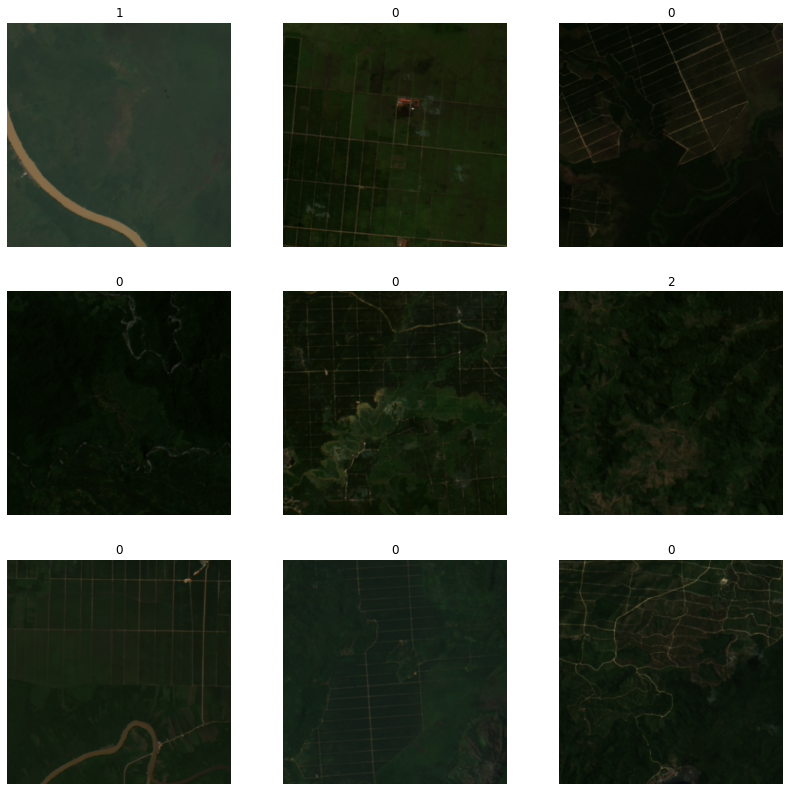

In [10]:
dls.show_batch(max_n=9, figsize=(14,14))

Checking vocab classes

In [11]:
dls.vocab

[0, 1, 2]

## Time to make and train a model!

We will be using a convolutional neural network backbone and a fully connected head with a single hidden layer as our classifier.

First, we need to make our Neural Network and our `Learner` like before. 

A `Learner` needs (on a base level):

* `DataLoaders`
* Some architecture
* A evaluation metric
* A loss function
* An optimizer

We'll also use `mixed_precision` (`fp16`)

In [12]:
learn = vision_learner(dls, resnet34, pretrained=True, metrics=error_rate).to_fp16()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Some assumptions being made here:

* Loss function is assumed as classification, so `CrossEntropyFlat`
* Optimizer is assumed to be Adam

Now, we can train it! We will train it for four cycles through all our data

In [13]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.817183,1.074137,0.453216,00:19
1,1.542228,0.952520,0.330409,00:16
2,1.276383,0.917389,0.318713,00:16
3,1.094949,0.881090,0.280702,00:16
4,0.986091,0.892979,0.280702,00:16
5,0.881047,0.835491,0.257310,00:16
6,0.796929,0.797331,0.274854,00:17
7,0.727607,0.802674,0.274854,00:15
8,0.706429,0.802405,0.269006,00:17
9,0.664718,0.799414,0.266082,00:15


In [14]:
learn.save('stage_1')

Path('models/stage_1.pth')

## Lets look at our results

With the model trained, let's look at where our it might've messed up. What class did it have trouble differentiating between? So long as the misidentifications are not too crazy, our model is actually working.

Let's plot our losses and make a confusion matrix to visualize this:

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

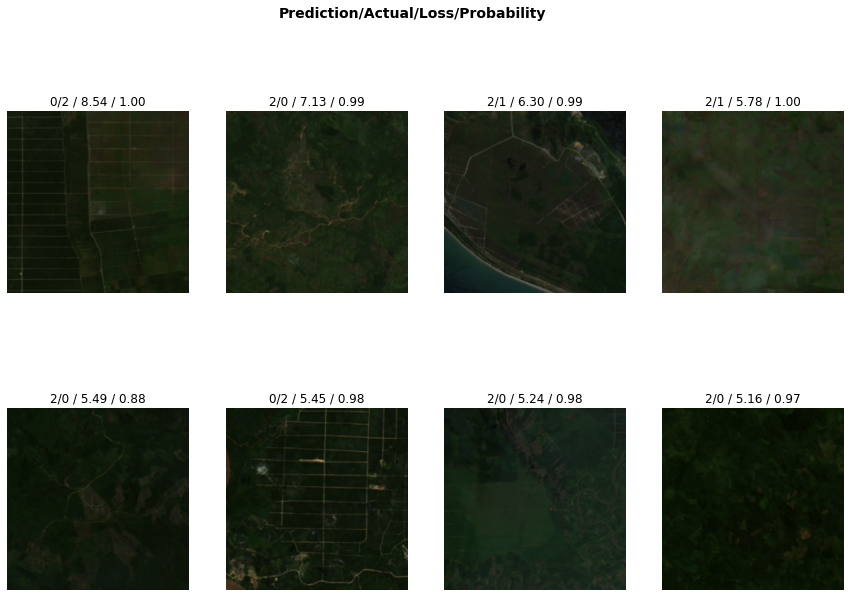

In [16]:
interp.plot_top_losses(8, figsize=(15,10))

`plot_confusion_matrix` just needs a figure size. dpi adjusts the quality

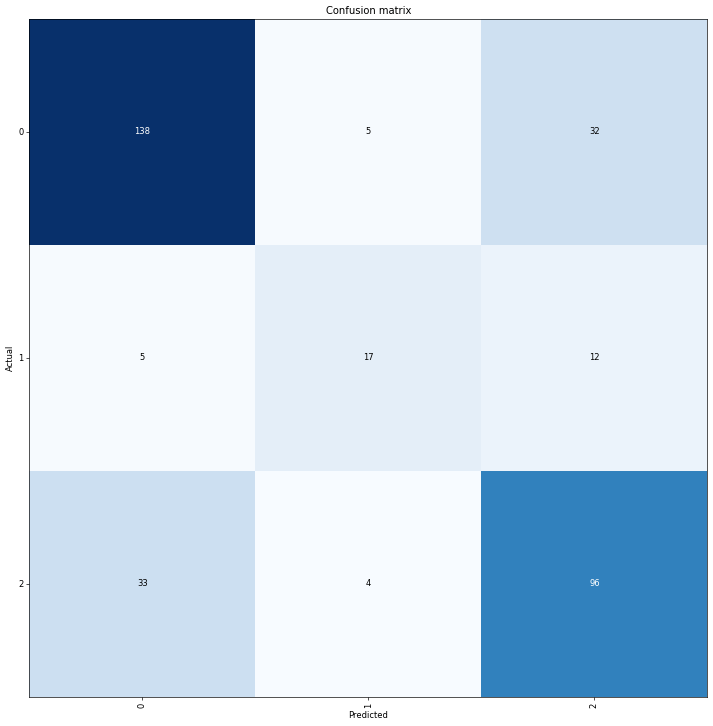

In [17]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

We can also directly grab our most confused (A raw version of the confusion matrix), and pass in a threshold

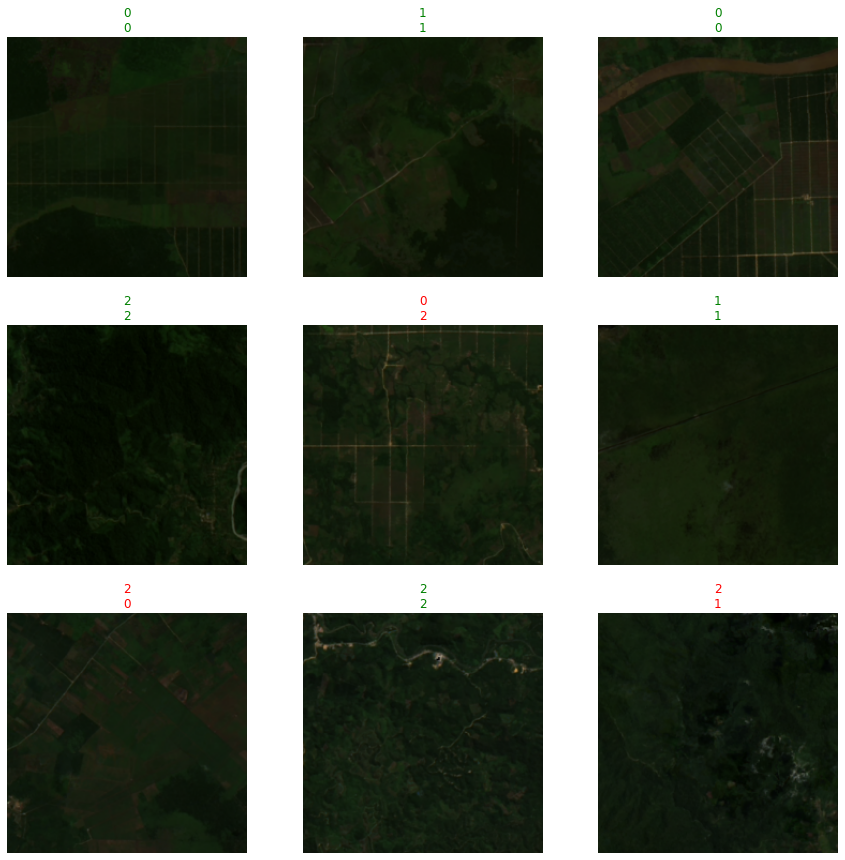

In [18]:
learn.show_results(figsize=(15,15))

In [19]:
interp.most_confused(min_val=3)

[(2, 0, 33), (0, 2, 32), (1, 2, 12), (0, 1, 5), (1, 0, 5), (2, 1, 4)]

## Unfreezing our data, fine-tuning, and our learning rates

So, we have the model. Let's fine tune it. First, we need to load our model back in.

In [20]:
learn.load('stage_1');

Now we will *unfreeze* and train more

In [21]:
learn.unfreeze()

In [22]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.654064,1.507439,0.365497,00:16
1,0.761638,1.479027,0.500000,00:16
2,0.831727,2.191769,0.374269,00:16
3,0.777781,1.137723,0.426901,00:16
4,0.728824,0.885833,0.365497,00:16
5,0.657172,0.632754,0.233918,00:16
6,0.590595,0.591307,0.222222,00:17
7,0.518406,0.529641,0.204678,00:16
8,0.462815,0.559457,0.195906,00:16
9,0.418065,0.555264,0.195906,00:16


Now when we `unfreeze`, we unfreeze *all* the layers. So to show how a difference of a proper learning rate looks, let's load in those old weights and try using `lr_find()`

In [23]:
learn.load('stage_1');

SuggestedLRs(valley=0.0002754228771664202)

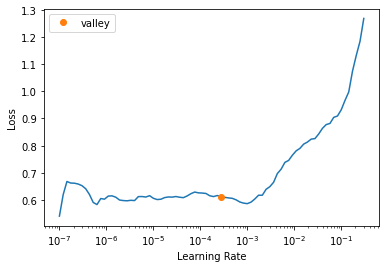

In [24]:
learn.lr_find()

Alright so if we look here, we don't start really spiking our losses until ~10^-2 so a good spot is between 1e-5 and 1e-3, let's do that!

In [25]:
learn.unfreeze()
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.656529,0.799785,0.269006,00:16
1,0.603445,0.877860,0.248538,00:16
2,0.577937,0.865432,0.257310,00:17
3,0.546807,0.866030,0.248538,00:16
4,0.482093,0.925149,0.260234,00:16
5,0.410224,0.858405,0.257310,00:17
6,0.358818,0.868374,0.254386,00:16
7,0.302989,0.838787,0.233918,00:16
8,0.255696,0.850455,0.242690,00:16
9,0.229909,0.836643,0.239766,00:16


We can see that picking a proper learning rate can help speed things up!

In [26]:
learn.save('stage_2')

Path('models/stage_2.pth')

## Now lets try with a resnet50!

If you need to restart your kernel due to memory errors I've attached the `dls` code below

In [27]:
deforest = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_x=ColReader(4, pref=f'/content/'),
                  get_y=ColReader(0),
                  splitter =RandomSplitter(),
                  item_tfms = item_tfms,
                  batch_tfms = batch_tfms,
                  )
dls = deforest.dataloaders(df_train)

In [28]:
f1score = F1Score(average='macro')

In [29]:
learn = cnn_learner(dls, resnet50, pretrained=True, metrics=[error_rate, accuracy, f1score]).to_fp16()

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0010000000474974513)

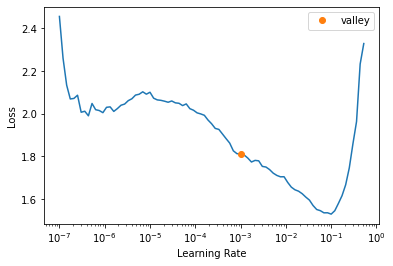

In [30]:
learn.lr_find()

In [31]:
lr = 0.009120108559727669

Let's train our model:

In [32]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,time
0,1.556039,0.928789,0.301170,0.698830,0.614126,00:16
1,1.321493,1.083767,0.292398,0.707602,0.615063,00:16
2,1.148452,0.814679,0.245614,0.754386,0.663925,00:16
3,0.995855,0.784372,0.236842,0.763158,0.685945,00:16


And save it:

In [33]:
learn.save('resnet50')

Path('models/resnet50.pth')

Now we will unfreeze and train more

In [34]:
learn.load('resnet50')
learn.unfreeze()
learn.fit_one_cycle(7, lr_max=4e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,time
0,0.819279,0.987068,0.257310,0.742690,0.587124,00:17
1,0.774275,1.804850,0.359649,0.640351,0.591266,00:17
2,0.802952,1.090489,0.239766,0.760234,0.611605,00:18
3,0.699878,0.844575,0.242690,0.757310,0.641255,00:17
4,0.603923,0.718104,0.219298,0.780702,0.711741,00:17
5,0.502888,0.644637,0.204678,0.795322,0.727099,00:17
6,0.417266,0.619562,0.207602,0.792398,0.730885,00:17


In [35]:
learn.save('resnet50')

Path('models/resnet50.pth')

Let's check our new confusion matrix

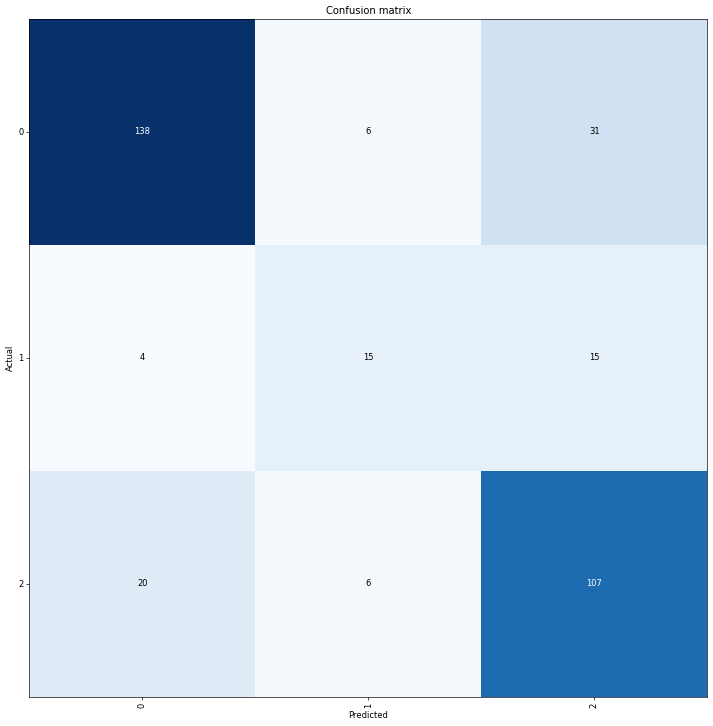

In [36]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

And plot the result of the training

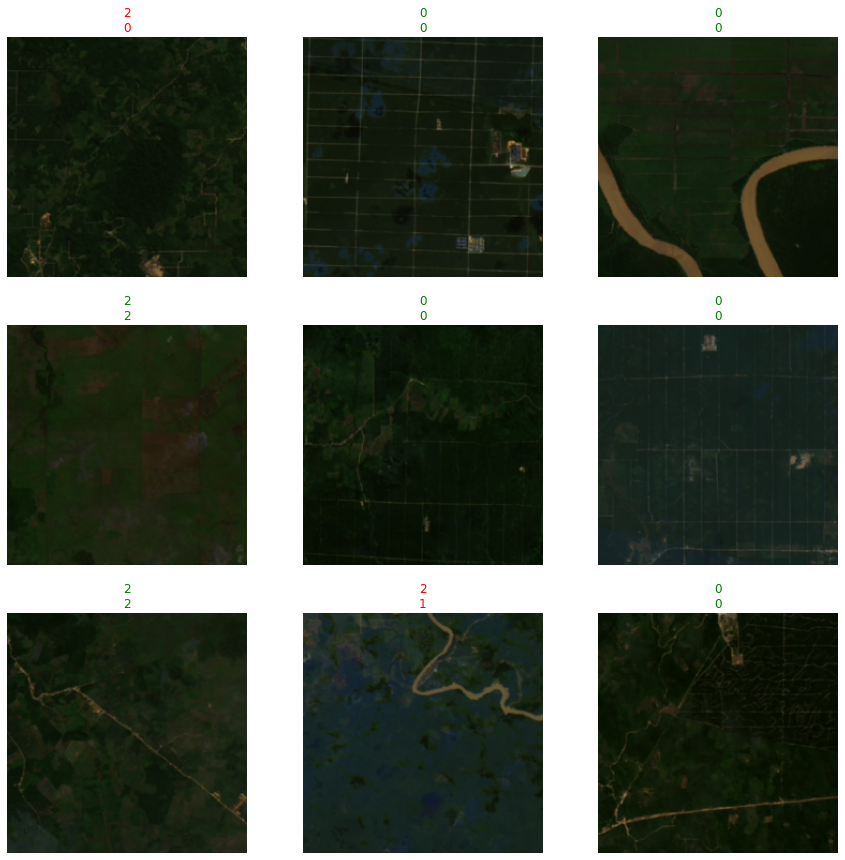

In [37]:
learn.show_results(figsize=(15,15))

Now, we are going to apply our model to the test images in 'test' folder

In [38]:
import numpy as np
from fastai.data.transforms import get_image_files
from sklearn.metrics import classification_report, confusion_matrix

def get_preds_on_test(learner, test_path, show_results=False):
    fnames = get_image_files(test_path)
    dl = learner.dls.test_dl(fnames)
    classes = learner.dls.vocab

    preds = [classes[i] for i in np.argmax(learner.get_preds(dl=dl)[0], 1)]

    return preds

preds = get_preds_on_test(learn, path+'/test',  True)

Now, we prepare the dataframe for export files

In [39]:
blocks = np.array(preds)

In [40]:
df_test['class_predicted'] = blocks.tolist()

In [41]:
df_test

,latitude,longitude,year,example_path,class_predicted
0,0.761681,122.755954,2006,train_test_data/test/69.png,2
1,-8.059785,113.053791,2007,train_test_data/test/469.png,0
2,-2.006610,111.746316,2002,train_test_data/test/6.png,2
3,0.901765,114.042495,2016,train_test_data/test/351.png,2
4,1.911210,100.829633,2008,train_test_data/test/1001.png,0
...,...,...,...,...,...
630,1.650899,101.314723,2011,train_test_data/test/968.png,0
631,-1.645649,102.612332,2010,train_test_data/test/54.png,0
632,-0.557796,114.561609,2016,train_test_data/test/494.png,0
633,-3.037549,113.872045,2009,train_test_data/test/287.png,2


Let's export our new test dataframe in csv format

In [42]:
df_test.to_csv('test_dataset_predicted.csv', index=True, header=True, encoding='utf-8')

Allow to download it

In [43]:
from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Preparing and cleaning data for json export

In [44]:
df_test['file_name'] = df_test['example_path'].apply(lambda st: st[st.find("test/")+5:st.find(".")])

In [45]:
predict_dic = dict(zip(df_test['file_name'], df_test['class_predicted']))

In [46]:
export_json = {"target" : predict_dic }

In [47]:
json_object = json.dumps(export_json) 
with open('predictions.json', 'w') as f:
  f.write(json_object)

files.download('predictions.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>